In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('North_American_Superstore.csv',encoding= 'unicode_escape')

In [4]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,7981,CA-2015-103800,2015/1/3,2015/1/7,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,740,CA-2015-112326,2015/1/4,2015/1/8,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2,741,CA-2015-112326,2015/1/4,2015/1/8,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748


In [5]:
# remove the space in the columns name
df.rename(columns = lambda x: x.replace(' ',''),inplace = True)

## 1. Data Preprocessing

### 1.1 Data Overview

In [6]:
def df_describe(df):
    print('The dataset contains {} rows and {} columns'.format(df.shape[0],df.shape[1]))
    print('*'*100)
    print(df.info())
    print('**100')
    print(df.describe())

df_describe(df) 

The dataset contains 9994 rows and 21 columns
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RowID         9994 non-null   int64  
 1   OrderID       9994 non-null   object 
 2   OrderDate     9994 non-null   object 
 3   ShipDate      9994 non-null   object 
 4   ShipMode      9994 non-null   object 
 5   CustomerID    9994 non-null   object 
 6   CustomerName  9994 non-null   object 
 7   Segment       9994 non-null   object 
 8   Country       9994 non-null   object 
 9   City          9994 non-null   object 
 10  State         9994 non-null   object 
 11  PostalCode    9983 non-null   float64
 12  Region        9994 non-null   object 
 13  ProductID     9994 non-null   object 
 14  Category      9994 non-null   object 
 15  Sub-Catego

### 1.2 Remove Duplicate Value

In [7]:
df = df.drop_duplicates() 

### 1.3 Handle Missing Value

In [8]:
df.isnull().sum()
df = df[~df['PostalCode'].isnull()] 

### 1.4 Check for potential outliers

In [9]:
# Check if there is any negative value in Sales or Quantity Columns
df.loc[(df.Sales< 0) | (df.Quantity<0)]

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,...,PostalCode,Region,ProductID,Category,Sub-Category,ProductName,Sales,Quantity,Discount,Profit


There is no outliers needed to be removed

### 1.5 Convert Date columns from str type to timestamp


In [10]:
date_col = ['OrderDate','ShipDate']
for col in date_col:
    df[col] = pd.to_datetime(df[col])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9983 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   RowID         9983 non-null   int64         
 1   OrderID       9983 non-null   object        
 2   OrderDate     9983 non-null   datetime64[ns]
 3   ShipDate      9983 non-null   datetime64[ns]
 4   ShipMode      9983 non-null   object        
 5   CustomerID    9983 non-null   object        
 6   CustomerName  9983 non-null   object        
 7   Segment       9983 non-null   object        
 8   Country       9983 non-null   object        
 9   City          9983 non-null   object        
 10  State         9983 non-null   object        
 11  PostalCode    9983 non-null   float64       
 12  Region        9983 non-null   object        
 13  ProductID     9983 non-null   object        
 14  Category      9983 non-null   object        
 15  Sub-Category  9983 non-null   object  

In [11]:
print('The latest order date：',df['OrderDate'].max())
print('The earliest order date：',df['OrderDate'].min())

The latest order date： 2018-12-30 00:00:00
The earliest order date： 2015-01-03 00:00:00


## 2. RFM Segmentation

RFM segmentation is a great method to identify and analyze groups of customers for special treatment. It helps company to make and exceute marketing plans to target specific clusters of customers that are much more relevant for their particular behavior – and thus generate much higher rates of response, plus increased loyalty and customer lifetime value. RFM stands for recency, frequency and monetary.



* Recency: The number of days that have passed since the customer last purchased ( How recently do they purchase? )

* Frequency: The number of purchases by the customer during a particular period of time ( How often do they purchase ? )

* Monetary:  The amount that the customer spend during a particular period of time ( How much do they spend ? )


Customers can be divivded into:

* Best Cusotmer：They transacted recently, do so often and spend more than other customers


* Churned Best Customers: They transacted frequently and spent a lot, but it’s been a long time since they’ve transacted 


* Lowest-Spending Active Loyal Customers：They transacted recently and do so often, but spend the least


* High-spending New Customers：They transacted only once, but very recently and they spent a lot

### 2.1 Obtain the  frequency of each customer(customerID) across the entire time period


In [80]:
df_copy = df.copy()
df_copy.drop_duplicates(subset=['OrderID'],keep='first',inplace=True) # removed the duplicate orderID 
df_freq = df_copy.groupby('CustomerID',as_index=False).OrderID.count().rename(columns = {'OrderID':'Frequency'})
df_freq.set_index('CustomerID')

,Frequency
CustomerID,
AA-10315,5
AA-10375,9
AA-10480,4
AA-10645,6
AB-10015,3
...,...
XP-21865,11
YC-21895,5
YS-21880,8


### 2.2 Obtain the total money spent (Monetary) and the days since the customers' last transaction(Recency)

In [81]:
df_group = df.groupby('CustomerID')
df_rm = df_group.agg({'Sales':'sum','OrderDate':'max'}).rename(columns={'Sales':'Monetary'})
df_rm['Recency'] = (pd.to_datetime('2019-01-01') - df_rm['OrderDate']).dt.days
df_rm = df_rm.drop('OrderDate',axis=1)
df_rm.head()

,Monetary,Recency
CustomerID,,
AA-10315,5563.560,186
AA-10375,1056.390,21
AA-10480,1790.512,261
AA-10645,5086.935,57
AB-10015,886.156,417


### 2.3  Obtain Frequency per year
 

### 2.4 Merge Recency, Frequency, Monetary and Profit by CustomerID 

In [89]:
df_RFM = df_rm.merge(df_freq,on = 'CustomerID').set_index('CustomerID')
df_RFM.head(5)

,Monetary,Recency,Frequency
CustomerID,,,
AA-10315,5563.560,186,5
AA-10375,1056.390,21,9
AA-10480,1790.512,261,4
AA-10645,5086.935,57,6
AB-10015,886.156,417,3


### 2.5 Divide the RFM segments based on the median of each measure

In [83]:
r_med = df_RFM['Recency'].median()
f_med = df_RFM['Frequency'].median()
m_med = df_RFM['Monetary'].median()
r_med,f_med,m_med

(78.0, 6.0, 2243.5099999999998)

In [95]:
# Divide customer types

def customer_type_func(df): 
    customer_type_list = []
    for i in range(len(df)):
        if df.iloc[i,1]>=r_med and df.iloc[i,2]>=f_med and df.iloc[i,0]>=m_med:
            customer_type_list.append('Churned Best Customers')  
        elif  df.iloc[i,1]< r_med and df.iloc[i,2]<f_med and df.iloc[i,0]>=m_med:
            customer_type_list.append("High-spending New Customers")  
        elif  df.iloc[i,1]< r_med and df.iloc[i,2]>=f_med and df.iloc[i,0]>=m_med:
            customer_type_list.append('Best Cusotmer')  
        elif  df.iloc[i,1] < r_med and df.iloc[i,2]>=f_med and df.iloc[i,0]<m_med:
            customer_type_list.append("Lowest-Spending Active Loyal Customers ") 
        else:
            customer_type_list.append('Normal')
    df['CustomerType'] = customer_type_list
customer_type_func(df_RFM)

In [96]:
df_RFM.head(5)

,Monetary,Recency,Frequency,CustomerType
CustomerID,,,,
AA-10315,5563.560,186,5,Normal
AA-10375,1056.390,21,9,Lowest-Spending Active Loyal Customers
AA-10480,1790.512,261,4,Normal
AA-10645,5086.935,57,6,Best Cusotmer
AB-10015,886.156,417,3,Normal


### 2.7 Visualization of  the customers' segments

Text(0.5, 1.0, 'Number of customers in each customer segments')

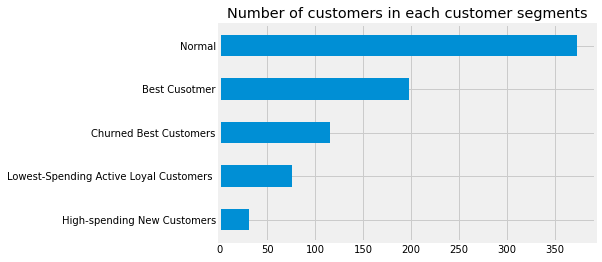

In [97]:
df_RFM['CustomerType'].value_counts(ascending=True).plot(kind = 'barh')
plt.title('Number of customers in each customer segments')

Text(0.5, 1.0, 'Percentage of customers in each segment')

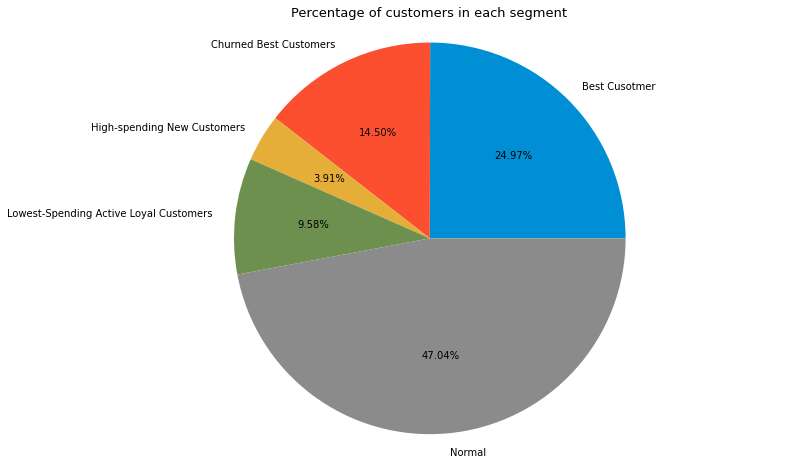

In [99]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
labels=df_RFM.groupby('CustomerType').CustomerType.size().index
customer_num=df_RFM.groupby('CustomerType').CustomerType.size()
ax1.pie(customer_num,explode=explode,labels=labels,textprops={'fontsize':10},shadow=False,autopct='%.2f%%')
ax1.axis('equal')
ax1.set_title('Percentage of customers in each segment',fontsize=13)

## 3. Summary

We can see Normal customers group accounted for over 45% of the total customers. However, Normal customers should be excluded in our RFM segments. 

* Best Customer Group accounted for the most within the RFM segmentation. these customers likely generate a disproportionately high percentage of overall revenues and thus focusing on keeping them happy should be a top priority.Further analyzing their individual preferences will provide additional opportunities for even higher profibility.


* Churned Best Customers accounted for 15% of the overall customers segment. Even though these valuale customer might stop purchasing for a period of long time and it's often challenging to re-engage churned customers, the high value of these customers makes it worthwhile trying. Like with the Best Customers group, it’s important to communicate with them on the basis of their specific preferences, as known from earlier transaction data.


* Lowest-Spending Active Loyal Customers are active and loyal, but they are low spenders. Marketers should create campaigns for this group that make them feel valued, and incentivize them to increase their spend levels. As loyal customers, it often also pays to reward them with special offers if they spread the word about the brand to their friends, e.g., via social networks.


* While maintaining a good relationship with existing customers, it's even more important to "incubate" new customer, especially for those who spent a lot on their first purchase. Like with the Best Customers group, it’s important to make them feel valued and appreciated by offer them terrifc incentives and excellent customer support to continue interacting with the brand.